In [2]:
import math
from itertools import chain
import torch
import matplotlib.pyplot as plt
import pandas as pd
from torch.nn.utils.rnn import pack_padded_sequence
from torch.utils.data import Dataset, DataLoader

## 数据集讲解

train.tsv是一个包含了14万条电影评论的文本文件，用于训练模型。该数据集包含了五列：PhraseId、SentenceId、Phrase、Sentiment和Aspect。其中：

PhraseId：评论的唯一标识符。

SentenceId：评论所在的句子的唯一标识符。

Phrase：电影评论的文本内容。

Sentiment：评论的情感极性标签，是一个5级分类标签，取值范围为0-4，分别表示“非常负面”、“稍微负面”、“中性”、“稍微正面”和“非常正面”。

https://www.kaggle.com/competitions/sentiment-analysis-on-movie-reviews/overview

In [3]:
data_train = pd.read_csv('./data/train.tsv',sep='\t')

In [4]:
data_train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [5]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156060 non-null  int64 
 1   SentenceId  156060 non-null  int64 
 2   Phrase      156060 non-null  object
 3   Sentiment   156060 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


In [6]:
#数据读取 创建数据集类
class NameDataset(Dataset):
    def __init__(self):
        self.train = pd.read_csv('./data/train.tsv',sep='\t')
        self.phrase = self.train['Phrase']
        self.sentiment = self.train['Sentiment']
        self.len=self.train.shape[0]
    
    def __getitem__(self,index):
        return self.phrase[index],self.sentiment[index]
    
    def __len__(self):
        return self.len

In [7]:
#设置超参数 准备训练工作
device = torch.device('cuda:0')
NUM_CHARS = 128
HIDDEN_SIZE = 128
NUM_LAYERS = 2
NUM_EPOCHS = 20
BATCH_SIZE = 512

In [8]:
#设置训练集和测试集
train_set = NameDataset()
train_loader=DataLoader(train_set,batch_size=BATCH_SIZE,shuffle=True)
NUM_CLASS = len(set(train_set.sentiment))

In [9]:
#定义RNN分类器
class RNNClassifier(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1, bidirectional=True):
        super(RNNClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_direction = 2 if bidirectional else 1
        self.embedding = torch.nn.Embedding(input_size, hidden_size)
        self.gru = torch.nn.GRU(hidden_size, hidden_size, n_layers, bidirectional=bidirectional)
        self.fc = torch.nn.Linear(hidden_size*self.n_direction, output_size)
    
    def _init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers*self.n_direction, batch_size, self.hidden_size)
        return hidden.to(device)·
    
    def forward(self, input, seq_lengths):
        input = input.t()
        batch_size = input.size(1)
        hidden = self._init_hidden(batch_size)
        embedding = self.embedding(input)
        gru_input = pack_padded_sequence(embedding, seq_lengths.cpu())
        output, hidden = self.gru(gru_input, hidden)
        if self.n_direction == 2:
            hidden_cat = torch.cat((hidden[-1], hidden[-2]), dim=1)
        else:
            hidden_cat = hidden[-1]
        fc_output = self.fc(hidden_cat)
        return fc_output

In [10]:
def phrase2list(phrase):
    arr = [ord(c) for c in phrase]
    return arr,len(arr)

def make_tensors(phrase,sentiment):
    sequences_and_lengths = [phrase2list(phrase) for phrase in phrase]
    phrase_sequences = [sl[0] for sl in sequences_and_lengths]
    seq_lengths = torch.LongTensor([sl[1] for sl in sequences_and_lengths])
    sentiment = sentiment.long()
    seq_tensor = torch.zeros(len(phrase_sequences), seq_lengths.max()).long()
    for idx, (seq, seq_len) in enumerate(zip(phrase_sequences, seq_lengths), 0):
        seq_tensor[idx, :seq_len] = torch.LongTensor(seq)
    seq_lengths, prem_idx = seq_lengths.sort(dim=0, descending=True)
    seq_tensor = seq_tensor[prem_idx]
    sentiment = sentiment[prem_idx]
    return seq_tensor.to(device), seq_lengths.to(device), sentiment.to(device)

In [11]:
def make_tensors1(phrase):
    sequences_and_lengths = [phrase2list(phrase) for phrase in phrase]
    phrase_sequences = [sl[0] for sl in sequences_and_lengths]
    seq_lengths = torch.LongTensor([sl[1] for sl in sequences_and_lengths])

    seq_tensor = torch.zeros(len(phrase_sequences), seq_lengths.max()).long()
    for idx, (seq, seq_len) in enumerate(zip(phrase_sequences, seq_lengths), 0):
        seq_tensor[idx, :seq_len] = torch.LongTensor(seq)
    seq_lengths, prem_idx = seq_lengths.sort(dim=0, descending=True)
    seq_tensor = seq_tensor[prem_idx]
    _, index = prem_idx.sort(descending=False)
    return seq_tensor.to(device), seq_lengths.to(device), index

In [12]:
#定义训练函数
def train():
    total_loss = 0
    for i, (phrase, sentiment) in enumerate(train_loader, 1):
        inputs, seq_lengths, target = make_tensors(phrase, sentiment)
        output = classifier(inputs, seq_lengths)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if i % 10 == 0:
            print(f'Epoch{epoch}', end='')
            print(f'[{i * len(inputs)}/{len(train_set)}]', end='')
            print(f'loss={total_loss / (i * len(inputs))}')
    return total_loss

In [13]:
#获得测试集
def get_test_set():
    test_set = pd.read_csv('./data/test.tsv','\t')
    PhraseId = test_set['PhraseId']
    test_Phrase = test_set['Phrase']
    return PhraseId,test_Phrase

In [14]:
def testModel():
    PhraseId, test_Phrase = get_test_set()
    sentiment_list = []  # 定义预测结果列表
    batchNum = math.ceil(PhraseId.shape[0] / BATCH_SIZE)
    with torch.no_grad():
        for i in range(batchNum):
            if i == batchNum - 1:
                phraseBatch = test_Phrase[BATCH_SIZE * i:]  # 处理最后不足BATCH_SIZE的情况
            else:
                phraseBatch = test_Phrase[BATCH_SIZE * i:BATCH_SIZE * (i + 1)]
            inputs, seq_lengths, org_idx = make_tensors1(phraseBatch)
            output = classifier(inputs, seq_lengths)
            sentiment = output.max(dim=1, keepdim=True)[1]
            sentiment = sentiment[org_idx].squeeze(1)
            sentiment_list.append(sentiment.cpu().numpy().tolist())
    sentiment_list = list(chain.from_iterable(sentiment_list))  # 将sentiment_list按行拼成一维列表
    result = pd.DataFrame({'PhraseId': PhraseId, 'Sentiment': sentiment_list})
    result.to_csv('SA_predict.csv', index=False)

In [15]:
classifier = RNNClassifier(NUM_CHARS, HIDDEN_SIZE, NUM_CLASS, NUM_LAYERS).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

In [17]:
classifier

RNNClassifier(
  (embedding): Embedding(128, 128)
  (gru): GRU(128, 128, num_layers=2, bidirectional=True)
  (fc): Linear(in_features=256, out_features=5, bias=True)
)

In [21]:
print('Training for %d epochs...' % NUM_EPOCHS)
acc_list = []
for epoch in range(1, NUM_EPOCHS + 1):
    train()
    acc = train()
    acc_list.append(acc)
    if acc <= min(acc_list):
        torch.save(classifier, 'sentimentAnalyst.pkl')
        print('Save Model!')

Training for 20 epochs...
Epoch1[5120/156060]loss=0.0026608567452058194
Epoch1[10240/156060]loss=0.0025765833794139325
Epoch1[15360/156060]loss=0.00253784095402807
Epoch1[20480/156060]loss=0.002517725987127051
Epoch1[25600/156060]loss=0.002492312118411064
Epoch1[30720/156060]loss=0.0024692273737552265
Epoch1[35840/156060]loss=0.002451006359686809
Epoch1[40960/156060]loss=0.002433622180251405
Epoch1[46080/156060]loss=0.0024201792638955844
Epoch1[51200/156060]loss=0.0024083239515312015
Epoch1[56320/156060]loss=0.002400630445812236
Epoch1[61440/156060]loss=0.002393620835694795
Epoch1[66560/156060]loss=0.002388130687177181
Epoch1[71680/156060]loss=0.0023829984345606395
Epoch1[76800/156060]loss=0.002376055253359179
Epoch1[81920/156060]loss=0.002367121538554784
Epoch1[87040/156060]loss=0.0023597973042770344
Epoch1[92160/156060]loss=0.0023507879697717724
Epoch1[97280/156060]loss=0.0023417050325262702
Epoch1[102400/156060]loss=0.002334904837189242
Epoch1[107520/156060]loss=0.002326759756986229

Epoch3[128000/156060]loss=0.0014272466604597868
Epoch3[133120/156060]loss=0.0014279799840341393
Epoch3[138240/156060]loss=0.0014274769182385945
Epoch3[143360/156060]loss=0.001427667887764983
Epoch3[148480/156060]loss=0.0014287422559673673
Epoch3[153600/156060]loss=0.001429610726966833
Save Model!
Epoch4[5120/156060]loss=0.0013201294117607177
Epoch4[10240/156060]loss=0.0012982906366232783
Epoch4[15360/156060]loss=0.0013071309852724273
Epoch4[20480/156060]loss=0.0013077536510536446
Epoch4[25600/156060]loss=0.0013149626832455396
Epoch4[30720/156060]loss=0.001320628175744787
Epoch4[35840/156060]loss=0.0013218212739697524
Epoch4[40960/156060]loss=0.0013251513824798166
Epoch4[46080/156060]loss=0.0013244282143811384
Epoch4[51200/156060]loss=0.00132990991929546
Epoch4[56320/156060]loss=0.001329168056095527
Epoch4[61440/156060]loss=0.001330995379248634
Epoch4[66560/156060]loss=0.0013329141003151353
Epoch4[71680/156060]loss=0.0013357568748428353
Epoch4[76800/156060]loss=0.0013381175968485573
Epo

Epoch6[97280/156060]loss=0.0010504042892104113
Epoch6[102400/156060]loss=0.0010530846132314764
Epoch6[107520/156060]loss=0.0010553444666411018
Epoch6[112640/156060]loss=0.0010577180139741606
Epoch6[117760/156060]loss=0.0010609130873648531
Epoch6[122880/156060]loss=0.0010620903568148302
Epoch6[128000/156060]loss=0.0010635260194540024
Epoch6[133120/156060]loss=0.001066758073060415
Epoch6[138240/156060]loss=0.0010680135188589769
Epoch6[143360/156060]loss=0.0010694214267589683
Epoch6[148480/156060]loss=0.0010707180300759602
Epoch6[153600/156060]loss=0.0010720395486957083
Save Model!
Epoch7[5120/156060]loss=0.000934968690853566
Epoch7[10240/156060]loss=0.0009393653454026207
Epoch7[15360/156060]loss=0.0009401823064157118
Epoch7[20480/156060]loss=0.0009421288734301925
Epoch7[25600/156060]loss=0.0009469635295681656
Epoch7[30720/156060]loss=0.0009518476765758047
Epoch7[35840/156060]loss=0.0009584800855788802
Epoch7[40960/156060]loss=0.0009618077652703505
Epoch7[46080/156060]loss=0.0009635522146

Epoch9[61440/156060]loss=0.0007359025946546657
Epoch9[66560/156060]loss=0.0007405058364383877
Epoch9[71680/156060]loss=0.0007428761446915035
Epoch9[76800/156060]loss=0.000745534059824422
Epoch9[81920/156060]loss=0.0007477875726181083
Epoch9[87040/156060]loss=0.0007523577444611446
Epoch9[92160/156060]loss=0.0007538505959221059
Epoch9[97280/156060]loss=0.0007579077543739817
Epoch9[102400/156060]loss=0.0007596145319985225
Epoch9[107520/156060]loss=0.0007618864127878277
Epoch9[112640/156060]loss=0.000764642552927729
Epoch9[117760/156060]loss=0.0007671607395067163
Epoch9[122880/156060]loss=0.0007692194805713371
Epoch9[128000/156060]loss=0.0007721533561125398
Epoch9[133120/156060]loss=0.0007750441611278803
Epoch9[138240/156060]loss=0.0007775809098449018
Epoch9[143360/156060]loss=0.0007800802191403429
Epoch9[148480/156060]loss=0.0007831940746561078
Epoch9[153600/156060]loss=0.0007840554848856604
Save Model!
Epoch10[5120/156060]loss=0.000644995883340016
Epoch10[10240/156060]loss=0.000654902384

Epoch12[10240/156060]loss=0.00045850804162910207
Epoch12[15360/156060]loss=0.00045338148969070366
Epoch12[20480/156060]loss=0.0004498439004237298
Epoch12[25600/156060]loss=0.0004582826467230916
Epoch12[30720/156060]loss=0.0004611360001338956
Epoch12[35840/156060]loss=0.00046103582717478276
Epoch12[40960/156060]loss=0.0004617071379470872
Epoch12[46080/156060]loss=0.00046239250449515464
Epoch12[51200/156060]loss=0.0004663257673382759
Epoch12[56320/156060]loss=0.00046874839674935424
Epoch12[61440/156060]loss=0.00047210054229556895
Epoch12[66560/156060]loss=0.0004744513580450215
Epoch12[71680/156060]loss=0.00047848010913834776
Epoch12[76800/156060]loss=0.0004810382295787955
Epoch12[81920/156060]loss=0.0004855070805206196
Epoch12[87040/156060]loss=0.0004882365574731546
Epoch12[92160/156060]loss=0.0004905239135647813
Epoch12[97280/156060]loss=0.0004930195773914947
Epoch12[102400/156060]loss=0.0004960465327894781
Epoch12[107520/156060]loss=0.0004987107381956386
Epoch12[112640/156060]loss=0.00

Epoch15[107520/156060]loss=0.0003577112785673567
Epoch15[112640/156060]loss=0.00035973602551331915
Epoch15[117760/156060]loss=0.00036214381132436836
Epoch15[122880/156060]loss=0.0003640017969397983
Epoch15[128000/156060]loss=0.00036765317211393266
Epoch15[133120/156060]loss=0.0003709631509711751
Epoch15[138240/156060]loss=0.000373804324556625
Epoch15[143360/156060]loss=0.0003767959751712624
Epoch15[148480/156060]loss=0.0003791605902169349
Epoch15[153600/156060]loss=0.0003818046015415651
Epoch15[5120/156060]loss=0.0003196325822500512
Epoch15[10240/156060]loss=0.0003120758090517484
Epoch15[15360/156060]loss=0.0003111180209089071
Epoch15[20480/156060]loss=0.00030844100256217645
Epoch15[25600/156060]loss=0.00030723418982233855
Epoch15[30720/156060]loss=0.00030947440488186356
Epoch15[35840/156060]loss=0.0003077767585637048
Epoch15[40960/156060]loss=0.00030710901592101436
Epoch15[46080/156060]loss=0.00030738786218636153
Epoch15[51200/156060]loss=0.00030831698299152774
Epoch15[56320/156060]lo

Epoch18[46080/156060]loss=0.0002440036901841975
Epoch18[51200/156060]loss=0.00024403904448263346
Epoch18[56320/156060]loss=0.00024397573883602904
Epoch18[61440/156060]loss=0.00024355453291112402
Epoch18[66560/156060]loss=0.00024458533376813505
Epoch18[71680/156060]loss=0.0002447288422055343
Epoch18[76800/156060]loss=0.00024629674929504595
Epoch18[81920/156060]loss=0.00024887797526389476
Epoch18[87040/156060]loss=0.0002495209679610151
Epoch18[92160/156060]loss=0.00025116519407472675
Epoch18[97280/156060]loss=0.0002534755325637219
Epoch18[102400/156060]loss=0.00025560330373991747
Epoch18[107520/156060]loss=0.00025828472273479704
Epoch18[112640/156060]loss=0.00025989084401358426
Epoch18[117760/156060]loss=0.00026248480704532044
Epoch18[122880/156060]loss=0.0002647435029454452
Epoch18[128000/156060]loss=0.0002670426785480231
Epoch18[133120/156060]loss=0.000269792912149569
Epoch18[138240/156060]loss=0.0002722002423036395
Epoch18[143360/156060]loss=0.0002739873735013784
Epoch18[148480/156060

Epoch20[133120/156060]loss=0.00024296759069189787
Epoch20[138240/156060]loss=0.0002450188716735553
Epoch20[143360/156060]loss=0.0002471349574729434
Epoch20[148480/156060]loss=0.00024918283206402676
Epoch20[153600/156060]loss=0.00025089399990974926
Save Model!


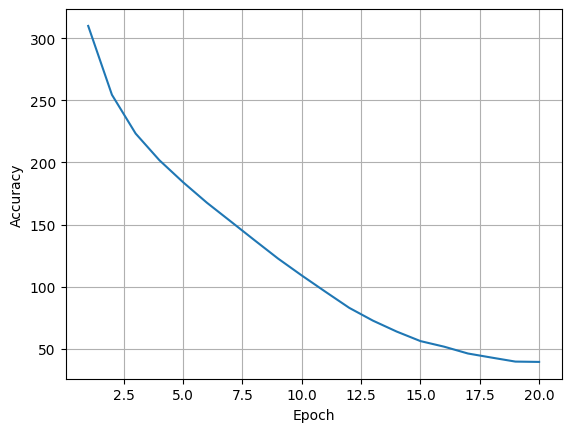

In [22]:
testModel()
epoch = [epoch + 1 for epoch in range(len(acc_list))]
plt.plot(epoch, acc_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()

https://www.bilibili.com/video/BV197411Z7Lh/

RNN分类器学习自李颖老师以及B站UP主“刘二大人”